# COVID-19 Pandemic Alert In Tirupati

## Introduction

### Background

Tirupati city, an attraction of millions of pilgrims & tourists every year, is a home for more than four lakh native people. It’s a city with a long history & culture and also a center for evolving business, technology, arts & culture. In Tirupati, people have a lot of first-aid centers & hospitals to get the help from.

### Problem Statement

For someone who is looking to open a pharmacy or clinic, it is vital to choose the neighborhood and retail location. The goal of this project is to figure out the places with less or no clinics nearby & where they should be set up to run successfully with the accurate data analysis. During the lockdown periods, this will help people find the pharmacy or first aid medicines in the detoured routes.

_During pandemic, COVID-19 having lockdowns this will also help us find out whether there is any nearby emergency medical shops in a particular area._

### Targeted Audience

<ol>
<li>People In the Neighborhood</li>
<li>Goverment Of Andhra Pradesh</li>
<li>Municipal Corporation of Tirupati</li>    
<li>Business People Interested in Pharma or Sanitizers</li></ol>

### Libraries Required

In [279]:
#Import libraries
import numpy as np #handles data in vactorized manner
import pandas as pd #handles data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json#handles JSON files

from geopy.geocoders import Nominatim #converts an address into latitude and longitude values

import requests #handles requests
from pandas.io.json import json_normalize # transform JSON file into a pandas datafame

#Import matplotlib and plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#Import k-means for clustering
from sklearn.cluster import KMeans

import folium #renders map

from math import radians, sin, cos, acos
import sys

##  Data Acquisition and Cleaning

### Data sources

The first thing that we need to solve the above problem is the exploration of locality. As I am from the same locality I have a decent knowledge in all the areas. That doesn't mean person with no knowledge on locality can do nothing here. To sort out all these problems I have listed all my gatherings and sources here.

First approach I did is, I Listed out all the Neighborhoods in the locality from the official website of Municipal Corporation of Tirupati. [Click_Here](https://tirupati.cdma.ap.gov.in/en/ward-profile). To go there.

For the Neighborhoods in that list we have to generate the Latitude and Longitude of each Neighborhood. For this I have used the **"geopy"** library

**lat_long_finder** The below method is used to pull the latitude and longitude of each neighborhood that we got from the above source.

In [280]:
def lat_long_finder(row):
    try:
        geolocator = Nominatim(user_agent="tpt_explorer")
    #         address = 'Tiruchanur Road, Tirupati, Andhra Pradesh, IN'

        location = geolocator.geocode(row)
        latitude = location.latitude
        longitude = location.longitude
        
        return (latitude,longitude)
    except:
        return None,None

Before Even we start our coding first will find out the latitide and longitude of **Tirupati** which will be helpful in drawing the maps by using folim library.

In [281]:
tpt_lat_lon = lat_long_finder("Tirupati, Andhra Pradesh, IN")
latitude = tpt_lat_lon[0]
longitude = tpt_lat_lon[1]  

As mentioned in my data source block the list of neighborhoods from the Municipal Corporation of Tirupati are saved in a CSV file. You can find that csv file in my git hub repository. The CSV file looks like below with one column having *Location* as the header

In [282]:
df = pd.read_csv("Tirupati_Wards_List.csv")
df.head()

,Location
0,"Akkarampalle, Tirupati, Andhra Pradesh, IN"
1,"Subbareddy Nagar, Tirupati, Andhra Pradesh, IN"
2,"TTD Quarters, Tirupati, Andhra Pradesh, IN"
3,"ASI Colony, Tirupati, Andhra Pradesh, IN"
4,"Sri Nagar, Tirupati, Andhra Pradesh, IN"


### Data Cleaning

As we have the list of Neighborhoods in Tirupati, Next task for us is to generate the latitude and longitude for each neighborhood in the list. To achieve this I have used the pandas **apply** method to iterate the process for all the vales in the list. The output from the method is a tuple with Latitude and Longitude of each Neighborhood. I am assigning the output to a new column named **Lat_Long**. As the Output from the above method is a tuple and we need it as two columns, for that I am again applying **lambda** function for the iterative process on the **Lat_Long** column to split it into two other columns. After we split the column and we have the required two columns we no longer need the **Lat_Long** column so dropping the column from that dataframe. To save this iterative process and to avoid running it through **geopy** again i am saving it as intermediate data file. Finally the output looks like below.

In [283]:
df['Lat_Long'] = df['Location'].apply(lat_long_finder)
df['latitude'] = df['Lat_Long'].apply(lambda x: x[0])
df['longitude'] = df['Lat_Long'].apply(lambda x: x[1])
df.dropna(axis=0, how='any',inplace=True)
df.drop(["Lat_Long"],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)
df.to_csv("Neighborhoods_Lat_Lng.csv",index=False)
df.head()

,Location,latitude,longitude
0,"TTD Quarters, Tirupati, Andhra Pradesh, IN",13.625078,79.423043
1,"Reddigunta, Tirupati, Andhra Pradesh, IN",13.758038,79.812770
2,"Tiruchanur Road, Tirupati, Andhra Pradesh, IN",13.631430,79.460467
3,"Renigunta Road, Tirupati, Andhra Pradesh, IN",13.638732,79.510476
4,"Karakambadi Road, Tirupati, Andhra Pradesh, IN",13.654813,79.469513


As a part of data collection I have to find the list of all the pharmacies in Tirupati with Some other parameters like **Rating**,**Total_Ratings**,**Latitude**,**Longitude**. I tried using the **Foursquare API** ended up with less number of data points. So I am left with no other option than using the **Google Places** API. So to minimize the number of calls to **Places** API and to cover the entire locality with less number of ovelaps. I have used the **kmeans** clustering logic to divde the neighborhoods with lat longs into n number of segements in such a way that it should full fill my requirement. I took the cluster centres to serch for near by pharmacies around those centres so that it covers the entire geography of Tirupati with optimum number of call and less duplicity. 
    
To visualize the above concept I have used **folium** library to prove my concept.

From the below map you can observe that there are circles with red dots in each circle. Each dot represent the centroid of that segment. So if you see there are n circles in the geography of tirupati which shows us that we have covered the location almost.

There is a white circle also in the middle showing like most of segments are inside the circle which means that the segments which are outside the white circle we can treat them as outskirts. 
  

In [262]:
tpt_wards_df = pd.read_csv("Neighborhoods_Lat_Lng.csv")
kclusters = 20

df_kmeans = tpt_wards_df.drop(['Location'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_kmeans)

cluster_centers = [[cc[0], cc[1]] for cc in kmeans.cluster_centers_]
[x.append(cluster_centers.index(x)) for x in cluster_centers]
cluster_labels = [cc for cc in kmeans.labels_]
tpt_wards_df['Labels'] = pd.DataFrame([item for item in cluster_labels])

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Circle([lat,lon], radius=3000, color='white', fill=True, fill_opacity=0.25).add_to(map_clusters)



for lat, lon,Name in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='orange', fill=True, fill_opacity=0.25).add_to(map_clusters)
    
for lat, lon, Name in cluster_centers:
    folium.CircleMarker([lat, lon], radius=5,popup=Name, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_clusters)

       
map_clusters

Once we have the cluster centres from the above algorithm we are converting the cluster centres with labels into a data frame for our further data collcetion process and data analysis part. The converted data frame looks like below.

In the below data frame **C_latitude**,**C_Longitude**,**Label** the columns represnt the centroid/segment latitude,longitude and label.

In [284]:
cluster_centers_df = pd.DataFrame([lat_lon for lat_lon in cluster_centers])
cluster_centers_df.columns = ["C_Latitude",'C_Longitude','Label']
cluster_centers_df.head()

,C_Latitude,C_Longitude,Label
0,13.611688,79.424375,0
1,13.643783,79.435583,1
2,13.632251,79.420186,2
3,13.659750,79.476500,3
4,13.625100,79.385800,4


### Google Places API

The below method **google_nearby_places** helps us in fetching the near by pharmacies of each segment within a particular radius. The maximum limit of this API is it can fetch only the places around the latitude and longitude in the range of 5km not more than that.

In the below method I pass group of labels,latitudes,longitudes from the above dataframe to get the results in shot by a iterative process instead of doing it each segment. Once we got the response for a particular centre from the API will run a iterative process inside the method to fetch only required fields and converting it to tuple and appending it to a list.

Finally from the method **google_nearby_places** will get a list with collection of tuples.

Now the **places list** from the above method is passed to **places_nearby_df** method which converts the list of tuples into a dataframe with a header assigned to it.

In [285]:
def google_nearby_places(labels,latitudes, longitudes, radius=1000):
    places_list = []
    search = "pharmacy"
    
    for label,latitude, longitude in zip(labels,latitudes, longitudes):          
        # create the API request URL
        url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&radius={}&types={}&key={}'\
        .format(latitude, longitude,radius,search,google_api_key)

        response = requests.get(url).json()
        
        
        for i in range(len(response['results'])):
            try:
                places_list.append([(response['results'][i]['id'],
                                     response['results'][i]['rating'],
                                     response['results'][i]['user_ratings_total'],
                                     response['results'][i]['geometry']['location']['lat'],
                                     response['results'][i]['geometry']['location']['lng'],
                                     response['results'][i]['name'],
                                     response['results'][i]['types'][0],
                                     response['results'][i]['vicinity'],
                                     label,latitude,longitude)])
            except:
                places_list.append([(response['results'][i]['id'],
                                     None,
                                     None,
                                     response['results'][i]['geometry']['location']['lat'],
                                     response['results'][i]['geometry']['location']['lng'],
                                     response['results'][i]['name'],
                                     response['results'][i]['types'][0],
                                     response['results'][i]['vicinity'],
                                     label,latitude,longitude)])

    return places_list

def places_nearby_df(places_list):
    nearby_places = pd.DataFrame([item for venues_list in places_list for item in venues_list])
    nearby_places.columns = ['ID','Rating','Total_Ratings','P_Latitude', 'P_Longitude', 'Place_Name', 'Place_Type', 'Place_Address','Label','C_Latitude','C_Longitude']
    
    return nearby_places

As we know the process of above two methods what is the input and what is the output. Now lets see how are we applying this to our project.

The **cluster_centers_df** from the previous method will be the input to **google_nearby_places** method.

The ouput from the method is list will give this as input to the **places_nearby_df**

From the above process finally will get a dataframe whic looks like below.

In [286]:
places_list = google_nearby_places(labels=cluster_centers_df['Label'],latitudes=cluster_centers_df['C_Latitude'],longitudes=cluster_centers_df['C_Longitude'])
tpt_pharmacies_df = places_nearby_df(places_list)
print(tpt_pharmacies_df.shape)
tpt_pharmacies_df_copy = tpt_pharmacies_df
tpt_pharmacies_df_copy.head()

(227, 11)


,ID,Rating,Total_Ratings,P_Latitude,P_Longitude,Place_Name,Place_Type,Place_Address,Label,C_Latitude,C_Longitude
0,4db22a4b2d44968e4237b5a4e2ea03cddda15508,4.8,4.0,13.617692,79.422581,New Ganesh Pharmacy,pharmacy,"Bairagipatteda, Tirupati",0,13.611688,79.424375
1,90879449a1d453b2f3f1bc94d54c06a6b5efe76b,NaN,NaN,13.617862,79.422495,Tejasree Medicals & Fancy Shop,pharmacy,"19-12-548, Avilala Road, Bairagi patteda, Tiru...",0,13.611688,79.424375
2,98edccf58a6126ec78767b5b219a65d0dae3001e,NaN,NaN,13.618355,79.422433,City Pharmacy,pharmacy,"Unnamed Road, STV Nagar, Tirupati",0,13.611688,79.424375
3,fdc01f85efbc3e363f8885d09c2c7f71d0780192,3.8,5.0,13.647799,79.430087,Apollo Pharmacy,pharmacy,"Door No 21/2/170/D, Jeeva Kona, Main Road, Sat...",1,13.643783,79.435583
4,fdbd70e5983fa5628714e73ca39a9dccbbb2cd6e,4.5,4.0,13.642131,79.428316,Apollo Pharmacy,pharmacy,"Door No 20/3/123/4/C Shop no 3 AK Palli, Road,...",1,13.643783,79.435583


There is a less chance of the data duplicity still we don't have to take a chance or introduce noise to the algorithm.

To achieve that we are removing the duplicated from the above dataframe.

I have seen there are some places with no ratings available from the **Places** API. So i am filling them with Zeros instead of dropping becuase will be left with less number of data points we drop every point which doesn't match our criteria.

Once we have filled the *NA*'s with Zeros now will clean the dataframe to make it look self explanatory.

I have dropped the columns which are not required for our process column names are given by:

**ID** The place ID which adds no value to our algorithm except to check the duplicity

**PLace_Type** The type of the place as we are searching from specific keywords like *Pharmacy* It Adds No value

**Place_Address** The address of the store this might be helpful but not now.

After doing all the above the cleansed data frame which will be used for further analysis looks like below.

In [287]:
tpt_pharmacies_df_copy.drop_duplicates(subset =['ID','Rating','Total_Ratings','P_Latitude', 'P_Longitude', 'Place_Name', 'Place_Type', 'Place_Address'], keep = 'first', inplace = True)
tpt_pharmacies_df_copy.fillna(0,inplace=True)
tpt_pharmacies_df_copy.drop(["ID","Place_Type","Place_Address"],1,inplace=True)
tpt_pharmacies_df_copy.head()

,Rating,Total_Ratings,P_Latitude,P_Longitude,Place_Name,Label,C_Latitude,C_Longitude
0,4.8,4.0,13.617692,79.422581,New Ganesh Pharmacy,0,13.611688,79.424375
1,0.0,0.0,13.617862,79.422495,Tejasree Medicals & Fancy Shop,0,13.611688,79.424375
2,0.0,0.0,13.618355,79.422433,City Pharmacy,0,13.611688,79.424375
3,3.8,5.0,13.647799,79.430087,Apollo Pharmacy,1,13.643783,79.435583
4,4.5,4.0,13.642131,79.428316,Apollo Pharmacy,1,13.643783,79.435583


### Exploratory Data Analysis

To add value to our solution instead of simply telling which segments have Medical stores available and Segments doesn't have medical stores. We can also segment the availabe Medical shops into different categories. To do that we need to analyze the ratings of each place. We are going to do the same in the below cell.

Initially I have drawn a bar plot between *Place_Name* and *Rating* I have seen most of the places have highest ratings.
when i have drilled down the analysis if we see how most of the places have highest ratings is there are only one or two entries for certain number of stores and those are highest so why most of our stores have highest ratings.

If you see the below box plots of two different categories like *rating* and *Total_Ratings*:

The first plot tells us that most of the stores have not more than 10 ratings in total per store.

But to the right the second plot tells us that most of the stores will fall under ratings 3.5 and above.

This is not redundant that we can trust the rating of that store only. So we have to consider the Number of Ratings also to evaluate a store.

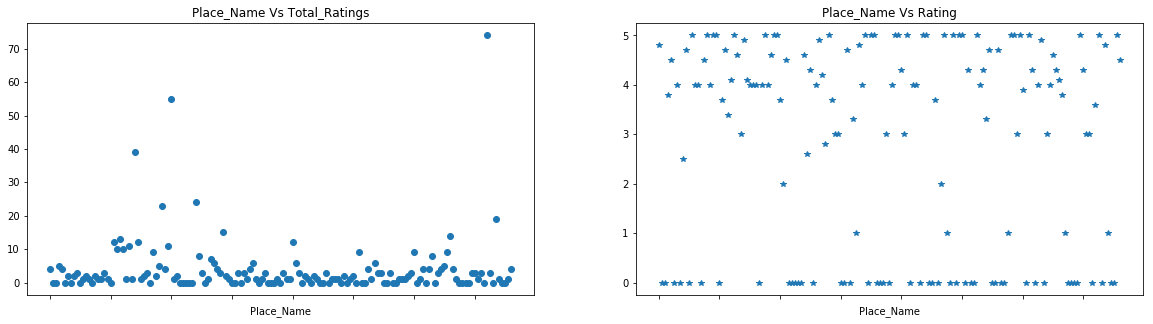

In [229]:
fig = plt.figure(figsize=(20,5))
# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
ax1.set_title("Place_Name Vs Total_Ratings")

# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)
ax2.set_title("Place_Name Vs Rating")

tpt_pharmacies_df_copy.plot(x='Place_Name', y='Total_Ratings', ax=ax1, style='o', legend=False)
tpt_pharmacies_df_copy.plot(x='Place_Name', y='Rating', ax=ax2, style='*', legend=False)

For further analysis and to give more intutive information about each store to the stake holders.

We are calculating the distance between the segmentcentre and the store location.

For that i am using the below method the formula to calculate the distance between two latitudes and longitdes is given by:

**dist = 6371.01 *** acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))**


In [230]:
def distance_calculator(P_Latitude,P_Longitude,Centre_Latitude,Centre_Longitude):
    slat = radians(float(P_Latitude))
    slon = radians(float(P_Longitude))
    elat = radians(float(Centre_Latitude))
    elon = radians(float(Centre_Longitude))

    dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
    
    return round(dist,2)

To do that for all the rows in the dataframe we are using pandas udf lambda function and storing the output into a "Distance" column. The distance measured from the above formula will give the result in km for better understanding I am converting them to metres.

The final dataframe looks like below.

In [288]:
tpt_pharmacies_df_copy['Distance'] = tpt_pharmacies_df_copy.apply(lambda row: distance_calculator(row['P_Latitude'], row['P_Longitude'], row['C_Latitude'], row['C_Longitude']), axis=1)
tpt_pharmacies_df_copy.head()

,Rating,Total_Ratings,P_Latitude,P_Longitude,Place_Name,Label,C_Latitude,C_Longitude,Distance
0,4.8,4.0,13.617692,79.422581,New Ganesh Pharmacy,0,13.611688,79.424375,0.70
1,0.0,0.0,13.617862,79.422495,Tejasree Medicals & Fancy Shop,0,13.611688,79.424375,0.72
2,0.0,0.0,13.618355,79.422433,City Pharmacy,0,13.611688,79.424375,0.77
3,3.8,5.0,13.647799,79.430087,Apollo Pharmacy,1,13.643783,79.435583,0.74
4,4.5,4.0,13.642131,79.428316,Apollo Pharmacy,1,13.643783,79.435583,0.81


## Modeling

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. It is popular for cluster analysis in data mining. k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, better Euclidean solutions can be found using k-medians and k-medoids.

Now we have the brief about what is **k-means** and what it does. Now how it helps me in my problem solving.

Along with the finding of segments with less number of Medical Stores I wanted to give a add on by segemnting the availabe medical shops into three categories **Good**,**Average**,**Cant'Say**. From the exploratory data analysis above I found that we have to give both **Total ratings** and **Rating** of the cluster as input to **k-means** to segment them into three categories.

So from the cleansed dataframe we take only required columns and process them through the algorithm to get the labels for each store. Once we have the Lables from the Algorithm we can I ball the data and categorize them into our categories.

In [290]:
pharma_clusters = 3
pharma_df = tpt_pharmacies_df_copy
df_kmeans = tpt_pharmacies_df_copy[["Total_Ratings","Rating"]]
pharma_kmeans = KMeans(n_clusters=pharma_clusters, random_state=0).fit(df_kmeans)
pharma_cluster_labels = [cc for cc in pharma_kmeans.labels_]
pharma_df['Cluster_Labels'] = pd.DataFrame([item for item in pharma_cluster_labels])
pharma_df.fillna(0,inplace=True)
print(pharma_df['Cluster_Labels'].unique())

[0. 2. 1.]


As the input for our algorithm is numerical data the output will also be in numerical type. If we see the above output we have three labels called **0** **1** **2** Now its time to convert them to Categorical labels by eye-balling the data.

If we have a look at the data with labels **0** most of the stores ratings are high and the total number of ratings availabe are less. So we can say that **Cluster_Labels** with **0** cannot be determined as either **Good** or **bad** with the data that we have.

In [291]:
pharma_df[pharma_df['Cluster_Labels'] == 0].head(10)

,Rating,Total_Ratings,P_Latitude,P_Longitude,Place_Name,Label,C_Latitude,C_Longitude,Distance,Cluster_Labels
0,4.8,4.0,13.617692,79.422581,New Ganesh Pharmacy,0,13.611688,79.424375,0.70,0.0
1,0.0,0.0,13.617862,79.422495,Tejasree Medicals & Fancy Shop,0,13.611688,79.424375,0.72,0.0
2,0.0,0.0,13.618355,79.422433,City Pharmacy,0,13.611688,79.424375,0.77,0.0
3,3.8,5.0,13.647799,79.430087,Apollo Pharmacy,1,13.643783,79.435583,0.74,0.0
4,4.5,4.0,13.642131,79.428316,Apollo Pharmacy,1,13.643783,79.435583,0.81,0.0
5,0.0,0.0,13.643108,79.432346,Sri Venkateswara Family Clinic,1,13.643783,79.435583,0.36,0.0
6,4.0,2.0,13.642236,79.430497,Gayathri Medical & Fancy,1,13.643783,79.435583,0.58,0.0
7,0.0,0.0,13.644531,79.430123,Sri guru pharmacy,1,13.643783,79.435583,0.60,0.0
8,2.5,2.0,13.642339,79.429211,New Gogula Medicals,1,13.643783,79.435583,0.71,0.0
9,4.7,3.0,13.642024,79.429295,Yuvan Medicals & Fancy,1,13.643783,79.435583,0.71,0.0


If we have a look at the data with labels **1** the stores ratings and and the total number of ratings availabe are good. So we can say that **Cluster_Labels** with **0** can be determined as **Good** with the data that we have.

In [292]:
pharma_df[pharma_df['Cluster_Labels'] == 1].head(10)

,Rating,Total_Ratings,P_Latitude,P_Longitude,Place_Name,Label,C_Latitude,C_Longitude,Distance,Cluster_Labels
28,4.9,39.0,13.632915,79.413075,AR Medicals,2,13.632251,79.420186,0.77,1.0
40,3.7,55.0,13.633862,79.420609,Hema vet & Poultry Medicals,2,13.632251,79.420186,0.18,1.0


If we have a look at the data with labels **2** the stores ratings and and the total number of ratings availabe are average. So we can say that **Cluster_Labels** with **2** can be determined as **Average** with the data that we have.

In [293]:
pharma_df[pharma_df['Cluster_Labels'] == 2].head(10)

,Rating,Total_Ratings,P_Latitude,P_Longitude,Place_Name,Label,C_Latitude,C_Longitude,Distance,Cluster_Labels
21,3.7,12.0,13.633820,79.419643,Apollo Pharmacy,2,13.632251,79.420186,0.18,2.0
22,4.7,10.0,13.634697,79.417964,Sai Balaji Medical & Surgical Distributors,2,13.632251,79.420186,0.36,2.0
23,3.4,13.0,13.637172,79.419852,Apollo Pharmacy,2,13.632251,79.420186,0.55,2.0
24,4.1,10.0,13.636879,79.418317,MedPlus Thyagaraja Nagar,2,13.632251,79.420186,0.55,2.0
26,4.6,11.0,13.637238,79.416628,Galaxy Medical Distribution,2,13.632251,79.420186,0.67,2.0
29,4.1,12.0,13.636763,79.427966,Apollo Pharmacy,2,13.632251,79.420186,0.98,2.0
34,4.0,9.0,13.633667,79.420516,Sri Venkatasai Homoeo Medical Stores,2,13.632251,79.420186,0.16,2.0
37,4.6,23.0,13.633832,79.420441,Pavan's Pet's Mart,2,13.632251,79.420186,0.18,2.0
39,5.0,11.0,13.633889,79.420362,Vani Medicals,2,13.632251,79.420186,0.18,2.0
48,4.6,24.0,13.642759,79.409320,Adithya Pharmacy,5,13.646931,79.412958,0.61,2.0


### Visualize the Output

In [295]:
# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

for lat, lon,Name in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='orange', fill=True, fill_opacity=0.25).add_to(map_clusters)

# set color scheme for the clusters
rainbow = ["brown","green","blue"]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,rating in zip(pharma_df['P_Latitude'], pharma_df['P_Longitude'], pharma_df['Place_Name'], pharma_df['Cluster_Labels'],pharma_df['Rating']):
#     print(cluster)
    cluster = int(cluster)
    label = folium.Popup(str(poi) + '-Cluster-' + str(cluster) +"-" +str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusion

If we see the above map things that we can conclude are given by:

<ol>
<li>Categories Of Stores</li>
<li>Segments With Density of Stores</li>
</ol>

As we have categorised the stores into three the
<ol>
<li>**Black** Good</li>
<li>**Green** Average</li>
<li>**Blue** Cannot Say</li>
</ol>

If you see most of the medical stores are in **Blue** colour which says us that either they are un explored by the people or those stores are not that popular or they don't have enough supplies for the people. So its better if we can explore them more before even we start anything further.

And the Segmentaion part the stores are not covering the entire geography of turupati location. There are location to be explored for Business holders. Before they start their business in that particular location. And to the people and Government, its an warning kind of signal to alert those regions about the availability of medicals during this pandemic period.

TO have specific analysis on each segemnt find the below output.

The header **Label** tells us about the segmnet ID and **count** is number of stores in that segment.

In [296]:
pharma_grouped = pd.DataFrame()
pharma_grouped['Label'] = cluster_centers_df["Label"]

pharma_grouped_dummy = tpt_pharmacies_df_copy[['Label','Distance']]
pharma_grouped_dummy = pharma_grouped_dummy.groupby(["Label"]).count().sort_values("Label", ascending=True)

pharma_dummy = pharma_grouped.merge(pharma_grouped_dummy,how='outer',on="Label")
pharma_dummy.fillna(0,inplace=True)
pharma_dummy.columns = ["Label","Count"]
pharma_dummy['Count'] = pharma_dummy['Count'].astype('int')
pharma_dummy.sort_values("Count", ascending=True)

,Label,Count
9,9,0
15,15,0
3,3,0
7,7,0
17,17,2
14,14,3
13,13,3
10,10,3
0,0,3
4,4,4


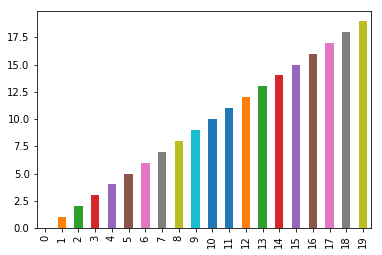

In [299]:
pharma_dummy['Label'].plot(kind='bar')